In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emachine as EM
import itertools
from joblib import Parallel, delayed
#from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(0)

In [3]:
n_var = 40 ; g = 1.0 ; n_seq = 5000

In [4]:
# Synthetic data are generated by using `generate_seq`.
w_true,seqs = EM.generate_seq(n_var,n_seq,g=g)
print(seqs.shape)

ops = EM.operators(seqs)
print(ops.shape)

(5000, 40)
(5000, 820)


In [5]:
# predict interactions w
eps_list = np.linspace(0.1,0.9,9)
n_eps = len(eps_list)
res = Parallel(n_jobs = n_eps)(delayed(EM.fit)(ops,eps=eps,max_iter=100) for eps in eps_list)
w_eps = np.array([res[i][0] for i in range(len(res))])
dw_eps = np.array([res[i][1] for i in range(len(res))])

#e_eps = np.zeros(len(eps_list))
#w_eps = np.zeros((len(eps_list),ops.shape[1]))
#for i,eps in enumerate(eps_list):
#    w_eps[i,:],e_eps[i] = EM.fit(ops,w_true,eps=eps,max_iter=100)
    #print('eps and e_eps:',eps,e_eps[i])

In [6]:
E = -ops.dot(w_eps.T)       # [n_seq,n_eps]
E_av = E.mean(axis=0)       # [n_eps]

dE = -ops.dot(dw_eps.T)     # [n_seq,n_eps]
dE_av = dE.mean(axis=0)     # [n_eps]

E1 = E - E_av[np.newaxis,:]
dE1 = dE - dE_av[np.newaxis,:]

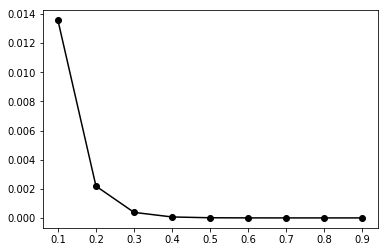

In [7]:
prob = np.exp(-E*(eps_list[np.newaxis,:]-1)) # [n_seq,n_eps]
norm = prob.sum(axis=0)[np.newaxis,:]        # [:,n_eps]
prob /= norm                                 # [n_seq,n_eps]

dEEE = (dE1*E1*E1*prob).mean(axis=0) 
plt.plot(eps_list,dEEE,'ko-')

In [8]:
# dE by another way
ops_av_data = ops.mean(axis=0) # [n_ops]

In [9]:
seqs_unique = np.unique(seqs,axis=0)
print(seqs_unique.shape)

ops_unique = EM.operators(seqs_unique)
print(ops_unique.shape)

(599, 40)
(599, 820)


In [10]:
E_unique = -ops_unique.dot(w_eps.T) # [n_seq,n_eps]

P_unique = np.exp(-E_unique)        # [n_seq,n_eps]
Z_unique = P_unique.mean(axis=0)[np.newaxis,:] # [:,n_eps]
P_unique /= Z_unique  # [n_seq,n_eps]

ops_av_unique = (ops_unique[:,:,np.newaxis]*P_unique[:,np.newaxis,:]).mean(axis=0) 
                # [n_seq,n_ops,:]*[n_seq,:,n_eps] --> [n_ops,n_eps] 
    

In [11]:
dE = ops.dot(ops_av_unique - ops_av_data[:,np.newaxis]) # [n_seq,n_eps]
dE_av = dE.mean(axis=0)
dE1 = dE - dE_av[np.newaxis,:]

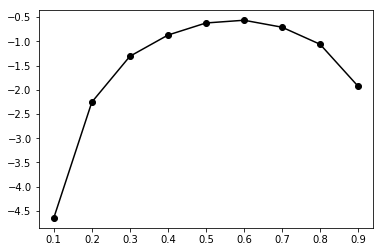

In [12]:
dEEE = (dE1*E1*E1*prob).mean(axis=0) 
plt.plot(eps_list,dEEE,'ko-')